In [6]:
import math
import time
import random
import pandas as pd

# Preparing Data

Creating datasets for each hole type and appending them into a list to reach them with ease

In [7]:
df = pd.read_csv("pcb_hole_coordinates.txt")
df_lsts = []
df_17 = df[df["radius"] == "1.7"].reset_index(drop=True).reset_index()
df_lsts.append(df_17)
df_15 = df[df["radius"] == "1.5"].reset_index(drop=True).reset_index()
df_lsts.append(df_15)
df_14 = df[df["radius"] == "1.4"].reset_index(drop=True).reset_index()
df_lsts.append(df_14)
df_13 = df[df["radius"] == "1.3"].reset_index(drop=True).reset_index()
df_lsts.append(df_13)
df_11 = df[df["radius"] == "1.118"].reset_index(drop=True).reset_index()
df_lsts.append(df_11)
df_10 = df[df["radius"] == "1"].reset_index(drop=True).reset_index()
df_lsts.append(df_10)
df_08a = df[df["radius"] == "0.8"].reset_index(drop=True).reset_index()
df_lsts.append(df_08a)
df_08b = df[df["radius"] == "0.8b"].reset_index(drop=True).reset_index()
df_lsts.append(df_08b)
df_075 = df[df["radius"] == "0.75"].reset_index(drop=True).reset_index()
df_lsts.append(df_075)
df_07 = df[df["radius"] == "0.7"].reset_index(drop=True).reset_index()
df_lsts.append(df_07)
df_04 = df[df["radius"] == "0.4"].reset_index(drop=True).reset_index()
df_lsts.append(df_04)

In [8]:
def calcDistance(holes): # There is a need for this function in each algorithm, this basically calculates distance between consecutive points
    total_sum = 0
    for i in range(len(holes) - 1):
        holeA = holes[i]
        holeB = holes[i + 1]
        d = math.sqrt(math.pow(holeB[1] - holeA[1], 2) + math.pow(holeB[2] - holeA[2], 2))
        total_sum += d
    holeA = holes[0]
    holeB = holes[-1]
    d = math.sqrt(math.pow(holeB[1] - holeA[1], 2) + math.pow(holeB[2] - holeA[2], 2))
    total_sum += d
    return total_sum


# Genetic Algorithm

In [9]:
def select_population(holes, size):
    population = []
    for i in range(size):
        # Create a copy to avoid modifying the original holes list
        c = holes.copy()
        # Randomly shuffle the order of elements (possible solutions)
        random.shuffle(c)
        # Calculate the fitness (distance) of the shuffled arrangement
        distance = calcDistance(c)
        # Add the [distance, solution] pair to the population
        population.append([distance, c])
    # Return the entire population and the best individual (lowest distance)
    return population, sorted(population)[0]


def crossover(parent1, parent2):
    # Randomly select two crossover points within the chromosome length
    start, end = sorted(random.sample(range(len(parent1)), 2))
    # Create an empty child chromosome
    child = [None] * len(parent1)
    # Copy a section of parent1's genes into the child
    child[start:end] = parent1[start:end]
    current_pos = end
    # Fill the remaining part of the child with unique genes from parent2
    for gene in parent2:
        if gene not in child:
            child[current_pos] = gene
            current_pos += 1
            # Wrap around if the end of the chromosome is reached
            if current_pos >= len(child):
                current_pos = 0
    return child


def genetic_algorithm(population, lenholes, tournament_size, mutation_rate, crossover_rate, target):
    start = time.time() # Record start time for performance tracking
    gen_number = 0
    for i in range(200): # Run for a maximum of 200 generations
        new_population = []

        # Elitism
        new_population.append(sorted(population)[0]) # Add the fittest individual
        new_population.append(sorted(population)[1]) # Add the second-fittest individual

        for i in range(int((len(population) - 2) / 2)):
            # Selection (tournament selection)
            if random.random() < crossover_rate:
                # Select parents using a tournament (randomly choose individuals and keep the best)
                parent1 = sorted(random.choices(population, k=tournament_size))[0][1]
                parent2 = sorted(random.choices(population, k=tournament_size))[0][1]
                # Crossover (create offspring)
                child1 = crossover(parent1, parent2)
                child2 = crossover(parent2, parent1)
            else:
                # If crossover is not selected, randomly choose parents for reproduction
                child1 = random.choices(population)[0][1]
                child2 = random.choices(population)[0][1]

            # Mutation (introduce random changes)
            if random.random() < mutation_rate:
                # Swap two random genes in child1
                point1, point2 = random.sample(range(len(child1)), 2)
                child1[point1], child1[point2] = child1[point2], child1[point1]
                point1, point2 = random.sample(range(len(child2)), 2)
                child2[point1], child2[point2] = child2[point2], child2[point1]

            new_population.append([calcDistance(child1), child1])
            new_population.append([calcDistance(child2), child2])

        population = new_population
        gen_number += 1

        if gen_number % 10 == 0:
            print(f"Generation {gen_number}: {sorted(population)[0][0]}")

        if sorted(population)[0][0] < target:
            break
    finish = time.time()
    time_passed = finish - start
    return sorted(population)[0], gen_number, time_passed

# Simulated Annealing

In [10]:
def simulated_annealing(holes, temp, cooling_rate):
    start = time.time()  # Record start time for performance tracking

    def swap_two_holes(route):
        """Swaps two randomly chosen elements in the route."""
        new_route = route.copy()  # Create a copy to avoid modifying the original route
        i, j = random.sample(range(len(route)), 2)  # Randomly select two indices
        new_route[i], new_route[j] = new_route[j], new_route[i]  # Swap elements at those indices
        return new_route

    current_solution = holes.copy()  # Initialize current solution as a copy of holes
    best_solution = holes.copy()  # Initialize the best solution as a copy of holes
    current_distance = calcDistance(current_solution)  # Calculate initial distance
    best_distance = current_distance  # Initialize best distance as initial distance

    while temp > 1:  # Loop until temperature cools down significantly
        new_solution = swap_two_holes(current_solution)  # Create a new solution by swapping elements
        new_distance = calcDistance(new_solution)  # Calculate the distance of the new solution

        # Accept the new solution if it's better or probabilistically based on temperature
        delta = current_distance - new_distance  # Calculate the difference in distance (improvement)
        sigmoid = math.exp(-max(min(delta / temp, 10), -10))
        if delta < 0 or random.random() < sigmoid:  # Metropolis criterion
            current_solution = new_solution  # Update current solution if accepted
            current_distance = new_distance  # Update current distance

            # Update best solution if the new solution is better
            if new_distance < best_distance:
                best_solution = new_solution
                best_distance = new_distance

        temp *= cooling_rate  # Decrease the temperature for the next iteration

    finish = time.time()  # Record end time
    time_passed = finish - start  # Calculate total execution time

    return best_solution, best_distance, time_passed


# Particle Swarm Optimization

In [11]:
class Particle:
    def __init__(self, holes):
        self.position = random.sample(holes, len(holes)) # Random initial position
        self.velocity = [0] * len(self.position) # Zero initial velocity for each dimension
        self.best_position = self.position # Copy of initial position as best so far
        self.best_distance = calcDistance(self.position) # Distance of the initial position

    def update_velocity(self, global_best_position, inertia, cognitive, social):
        """
        Updates the particle's velocity based on three components:
          - inertia: tendency to continue in the current direction
          - cognitive component: based on the particle's own best experience
          - social component: influenced by the swarm's global best position
        """
        new_velocity = []
        for i in range(len(self.position)):
            r1 = random.random()
            r2 = random.random()
            # Cognitive component: attracts particle towards its own best position
            cognitive_velocity = cognitive * r1 * (self.best_position[i][1] - self.position[i][1])
            # Social component: attracts particle towards the swarm's global best position
            social_velocity = social * r2 * (global_best_position[i][1] - self.position[i][1])
            # Update velocity using inertia, cognitive, and social components
            new_velocity.append(inertia * self.velocity[i] + cognitive_velocity + social_velocity)
        self.velocity = new_velocity

    def update_position(self):
        """
        Updates the particle's position based on its current velocity.
        Uses a sigmoid function to constrain the random number between -1 and 1
        for applying the velocity to the position.
        """
        new_position = self.position.copy()
        for i in range(len(new_position)):
            sigmoid = 1 / (1 + math.exp(-max(min(self.velocity[i], 10), -10)))  # constrain the input to exp()
            if random.random() < sigmoid:
                j = random.randint(0, len(new_position) - 1)
                new_position[i], new_position[j] = new_position[j], new_position[i]
        self.position = new_position
        new_distance = calcDistance(new_position)
        if new_distance < self.best_distance:
            self.best_position = new_position
            self.best_distance = new_distance # Update best distance if improved


def particle_swarm_optimization(holes, pop_size, inertia, cognitive, social, max_iter):
    """
    Implements the Particle Swarm Optimization (PSO) algorithm.

    Args:
        holes: The set of possible solutions (e.g., list of cities).
        pop_size: The number of particles in the swarm.
        inertia: Weight given to the particle's previous velocity.
        cognitive: Weight given to the particle's own best experience.
        social: Weight given to the swarm's global best position.
        max_iter: The maximum number of iterations.

    Returns:
        The best solution found, its distance, and the execution time.
    """
    start = time.time()
    swarm = [Particle(holes) for _ in range(pop_size)]
    global_best_position = min(swarm, key=lambda p: p.best_distance).best_position
    global_best_distance = calcDistance(global_best_position)

    for _ in range(max_iter):
        for particle in swarm:
            particle.update_velocity(global_best_position, inertia, cognitive, social)
            particle.update_position()
            if calcDistance(particle.best_position) < global_best_distance:
                global_best_position = particle.best_position
                global_best_distance = calcDistance(global_best_position)
    finish = time.time()
    time_passed = finish - start
    return global_best_position, global_best_distance, time_passed


In [47]:
def main(df):
    holes = df.values.tolist()

    # Genetic Algorithm parameters
    POPULATION_SIZE = 200
    TOURNAMENT_SELECTION_SIZE = 4
    MUTATION_RATE = 0.1
    CROSSOVER_RATE = 0.9
    TARGET = 450.0

    # Simulated Annealing parameters
    INITIAL_TEMP = 10000
    COOLING_RATE = 0.995

    # Particle Swarm Optimization parameters
    SWARM_SIZE = 30
    INERTIA = 0.5
    COGNITIVE = 1.5
    SOCIAL = 2.0
    MAX_ITER = 100

    # Run Genetic Algorithm
    print("Running Genetic Algorithm...")
    initial_population, _ = select_population(holes, POPULATION_SIZE)
    best_genetic, _, time_passed1 = genetic_algorithm(initial_population, len(holes), TOURNAMENT_SELECTION_SIZE,
                                                     MUTATION_RATE,
                                                     CROSSOVER_RATE, TARGET)
    print("Genetic Algorithm Best Distance:", best_genetic[0])
    print("Time:", time_passed1)

    # Run Simulated Annealing
    print("\nRunning Simulated Annealing...")
    best_sa, _, time_passed2 = simulated_annealing(holes, INITIAL_TEMP, COOLING_RATE)
    sa = [best_sa, _, time_passed2]
    print("Simulated Annealing Best Distance:", calcDistance(best_sa))
    print("Time:", time_passed2)

    # Run Particle Swarm Optimization
    print("\nRunning Particle Swarm Optimization...")
    best_pso, _, time_passed3 = particle_swarm_optimization(holes, SWARM_SIZE, INERTIA, COGNITIVE, SOCIAL, MAX_ITER)
    ps = [best_pso, _, time_passed3]
    print("Particle Swarm Optimization Best Distance:", calcDistance(best_pso))
    print("Time:", time_passed3)

    return best_genetic, sa, ps, time_passed1

# Putting Together Results

In [13]:
results = []

In [14]:
genetic, sa, ps, t1 = main(df_lsts[0])
results.append([4, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Genetic Algorithm Best Distance: 113.80584360149872
Time: 0.002089262008666992

Running Simulated Annealing...
Simulated Annealing Best Distance: 113.80584360149872
Time: 0.008901596069335938

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 113.80584360149872
Time: 0.031000375747680664


In [15]:
genetic, sa, ps, t1 = main(df_lsts[2])
results.append([16, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 897.6864544962248
Generation 20: 829.6113814783364
Generation 30: 777.6113814783363
Generation 40: 777.6113814783363
Generation 50: 777.6113814783363
Generation 60: 777.6113814783363
Generation 70: 777.6113814783363
Generation 80: 777.6113814783363
Generation 90: 777.6113814783363
Generation 100: 777.6113814783363
Generation 110: 777.6113814783363
Generation 120: 777.6113814783363
Generation 130: 777.6113814783363
Generation 140: 777.6113814783363
Generation 150: 777.6113814783363
Generation 160: 777.6113814783363
Generation 170: 777.6113814783363
Generation 180: 777.6113814783363
Generation 190: 777.6113814783363
Generation 200: 777.6113814783363
Genetic Algorithm Best Distance: 777.6113814783363
Time: 0.6183640956878662

Running Simulated Annealing...
Simulated Annealing Best Distance: 1238.2347527974696
Time: 0.01750969886779785

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1280.9066557407234
Time: 0.09

In [16]:
genetic, sa, ps, t1 = main(df_lsts[3])
results.append([29, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 5537.80109418534
Generation 20: 3873.009987659227
Generation 30: 3450.9101218642368
Generation 40: 3160.910121864237
Generation 50: 2854.9864582883492
Generation 60: 2825.3764953534205
Generation 70: 2658.9748680262746
Generation 80: 2652.1416688218997
Generation 90: 2538.9748680262746
Generation 100: 2459.1392221715396
Generation 110: 2459.1392221715396
Generation 120: 2377.8418345373984
Generation 130: 2342.8803098540557
Generation 140: 2308.8327618923563
Generation 150: 2144.0111606447767
Generation 160: 2084.0111606447767
Generation 170: 2053.0055803223886
Generation 180: 2053.0055803223886
Generation 190: 1993.0055803223884
Generation 200: 1993.0055803223884
Genetic Algorithm Best Distance: 1993.0055803223884
Time: 0.9082343578338623

Running Simulated Annealing...
Simulated Annealing Best Distance: 2462.5556722118417
Time: 0.024197816848754883

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 6776.412220

In [17]:
genetic, sa, ps, t1 = main(df_lsts[4])
results.append([8, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Genetic Algorithm Best Distance: 204.0
Time: 0.0020003318786621094

Running Simulated Annealing...
Simulated Annealing Best Distance: 193.48655719667784
Time: 0.011471986770629883

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 193.48655719667784
Time: 0.04952859878540039


In [18]:
genetic, sa, ps, t1 = main(df_lsts[5])
results.append([48, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 6130.466610766553
Generation 20: 5500.081462637234
Generation 30: 4309.884808276085
Generation 40: 3950.1923757323602
Generation 50: 3607.587295380387
Generation 60: 3148.3685358998036
Generation 70: 3085.910663190569
Generation 80: 2810.3784482284123
Generation 90: 2695.9611339067887
Generation 100: 2553.4625407216163
Generation 110: 2505.0612621875653
Generation 120: 2413.5257904786854
Generation 130: 2395.0497181202195
Generation 140: 2301.183057014591
Generation 150: 2277.6590900287383
Generation 160: 2225.86327287079
Generation 170: 2199.84717177444
Generation 180: 2042.8051992276653
Generation 190: 2030.1513685877558
Generation 200: 2019.9834286244436
Genetic Algorithm Best Distance: 2019.9834286244436
Time: 1.6803557872772217

Running Simulated Annealing...
Simulated Annealing Best Distance: 2712.752168971193
Time: 0.04117608070373535

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 7337.750605849776
T

In [48]:
genetic, sa, ps, t1 = main(df_lsts[6])
results.append([76, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 11296.990612406438
Generation 20: 9691.547563639906
Generation 30: 8490.083415216943
Generation 40: 7806.339942841256
Generation 50: 7223.157485192882
Generation 60: 7022.10735666843
Generation 70: 6635.55299664959
Generation 80: 6472.983009454546
Generation 90: 5907.275804673058
Generation 100: 5857.070048315908
Generation 110: 5705.437240913197
Generation 120: 5405.077018808298
Generation 130: 5158.2416604040245
Generation 140: 4995.144110057757
Generation 150: 4954.132088651436
Generation 160: 4854.326617740421
Generation 170: 4704.75973409154
Generation 180: 4650.120277371055
Generation 190: 4527.597222164447
Generation 200: 4472.341765087528
Genetic Algorithm Best Distance: 4472.341765087528
Time: 3.1950275897979736

Running Simulated Annealing...
Simulated Annealing Best Distance: 4346.774619047947
Time: 0.05578327178955078

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 12939.232332240304
Time: 4.0661

C:\Users\emrea\AppData\Local\Temp\ipykernel_26364\1768873596.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results.append([76, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])


,holes,Genetic,SA,PS,0
0,4.0,"[113, 0.002089262008666992]","[113, 0.008901596069335938]","[113, 0.031000375747680664]",NaN
1,16.0,"[777, 0.6183640956878662]","[1238, 0.01750969886779785]","[1280, 0.09253883361816406]",NaN
2,29.0,"[1993, 0.9082343578338623]","[2462, 0.024197816848754883]","[6776, 0.1493535041809082]",NaN
3,8.0,"[204, 0.0020003318786621094]","[193, 0.011471986770629883]","[193, 0.04952859878540039]",NaN
4,48.0,"[2019, 1.6803557872772217]","[2712, 0.04117608070373535]","[7337, 0.27698397636413574]",NaN
5,76.0,"[4656, 3.0246007442474365]","[4346, 0.05565047264099121]","[13193, 0.3992173671722412]",NaN
6,11.0,"[1416, 0.4091038703918457]","[1706, 0.011943340301513672]","[1738, 0.060207366943359375]",NaN
7,15.0,"[432, 0.03840756416320801]","[434, 0.015008687973022461]","[642, 0.08068299293518066]",NaN
8,16.0,"[656, 0.5165202617645264]","[1171, 0.015902280807495117]","[1007, 0.08732438087463379]",NaN
9,23.0,"[1069, 0.7093017101287842]","[1387, 0.020982742309570312]","[2298, 0.11956000328063965]",NaN


In [20]:
genetic, sa, ps, t1 = main(df_lsts[7])
results.append([11, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 1468.7205999411017
Generation 20: 1416.034152368577
Generation 30: 1416.034152368577
Generation 40: 1416.034152368577
Generation 50: 1416.034152368577
Generation 60: 1416.034152368577
Generation 70: 1416.034152368577
Generation 80: 1416.034152368577
Generation 90: 1416.034152368577
Generation 100: 1416.034152368577
Generation 110: 1416.034152368577
Generation 120: 1416.034152368577
Generation 130: 1416.034152368577
Generation 140: 1416.034152368577
Generation 150: 1416.034152368577
Generation 160: 1416.034152368577
Generation 170: 1416.034152368577
Generation 180: 1416.034152368577
Generation 190: 1416.034152368577
Generation 200: 1416.034152368577
Genetic Algorithm Best Distance: 1416.034152368577
Time: 0.4091038703918457

Running Simulated Annealing...
Simulated Annealing Best Distance: 1706.942763098653
Time: 0.011943340301513672

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1738.8066320673659
Time: 0.0

In [21]:
genetic, sa, ps, t1 = main(df_lsts[8])
results.append([15, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 472.1908633876204
Genetic Algorithm Best Distance: 432.1277950450951
Time: 0.03840756416320801

Running Simulated Annealing...
Simulated Annealing Best Distance: 434.9189777325438
Time: 0.015008687973022461

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 642.2844976397494
Time: 0.08068299293518066


In [22]:
genetic, sa, ps, t1 = main(df_lsts[9])
results.append([16, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 746.5223536610881
Generation 20: 712.0
Generation 30: 712.0
Generation 40: 712.0
Generation 50: 712.0
Generation 60: 712.0
Generation 70: 712.0
Generation 80: 712.0
Generation 90: 712.0
Generation 100: 712.0
Generation 110: 712.0
Generation 120: 712.0
Generation 130: 704.6165969494941
Generation 140: 691.6377637645163
Generation 150: 656.0
Generation 160: 656.0
Generation 170: 656.0
Generation 180: 656.0
Generation 190: 656.0
Generation 200: 656.0
Genetic Algorithm Best Distance: 656.0
Time: 0.5165202617645264

Running Simulated Annealing...
Simulated Annealing Best Distance: 1171.8684449137345
Time: 0.015902280807495117

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1007.1195536557136
Time: 0.08732438087463379


In [23]:
genetic, sa, ps, t1 = main(df_lsts[10])
results.append([23, [genetic[0], t1], [calcDistance(sa[0]), sa[2]], [calcDistance(ps[0]), ps[2]]])

Running Genetic Algorithm...
Generation 10: 1448.3715582086331
Generation 20: 1180.1638819130587
Generation 30: 1136.185089511685
Generation 40: 1092.8566268807992
Generation 50: 1092.8566268807992
Generation 60: 1084.7282238172509
Generation 70: 1081.1462737689465
Generation 80: 1072.9348158676403
Generation 90: 1069.3528658193359
Generation 100: 1069.3528658193359
Generation 110: 1069.3528658193359
Generation 120: 1069.3528658193359
Generation 130: 1069.3528658193359
Generation 140: 1069.3528658193359
Generation 150: 1069.2056846145315
Generation 160: 1069.205684614531
Generation 170: 1069.205684614531
Generation 180: 1069.205684614531
Generation 190: 1069.205684614531
Generation 200: 1069.205684614531
Genetic Algorithm Best Distance: 1069.205684614531
Time: 0.7093017101287842

Running Simulated Annealing...
Simulated Annealing Best Distance: 1387.3745498625758
Time: 0.020982742309570312

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 2298.898926626

In [24]:
results

[[4,
  [113.80584360149872, 0.002089262008666992],
  [113.80584360149872, 0.008901596069335938],
  [113.80584360149872, 0.031000375747680664]],
 [16,
  [777.6113814783363, 0.6183640956878662],
  [1238.2347527974696, 0.01750969886779785],
  [1280.9066557407234, 0.09253883361816406]],
 [29,
  [1993.0055803223884, 0.9082343578338623],
  [2462.5556722118417, 0.024197816848754883],
  [6776.4122206182765, 0.1493535041809082]],
 [8,
  [204.0, 0.0020003318786621094],
  [193.48655719667784, 0.011471986770629883],
  [193.48655719667784, 0.04952859878540039]],
 [48,
  [2019.9834286244436, 1.6803557872772217],
  [2712.752168971193, 0.04117608070373535],
  [7337.750605849776, 0.27698397636413574]],
 [76,
  [4656.439138087588, 3.0246007442474365],
  [4346.774619047947, 0.05565047264099121],
  [13193.088259490625, 0.3992173671722412]],
 [11,
  [1416.034152368577, 0.4091038703918457],
  [1706.942763098653, 0.011943340301513672],
  [1738.8066320673659, 0.060207366943359375]],
 [15,
  [432.1277950450951

In [25]:
import matplotlib.pyplot as plt

def plot_solution(cities, solution):
    # Extract coordinates
    x = [city[1] for city in solution]
    y = [city[2] for city in solution]

    # Plot points
    plt.scatter(x, y, color='blue')

    # Plot path
    for i in range(len(solution) - 1):
        plt.plot([solution[i][1], solution[i + 1][1]], [solution[i][2], solution[i + 1][2]], color='red')
    plt.plot([solution[-1][1], solution[0][1]], [solution[-1][2], solution[0][2]], color='red')  # Closing the loop

    # Set labels
    plt.title('PCB Drilling Path Optimization')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

In [26]:
for item in results:
    for i in range(1,4):
        item[i][0] = int(item[i][0])
results = pd.DataFrame(results, columns=["holes", "Genetic", "SA", "PS"])

# Investigating Results and Comparing Them

In [27]:
results

,holes,Genetic,SA,PS
0,4,"[113, 0.002089262008666992]","[113, 0.008901596069335938]","[113, 0.031000375747680664]"
1,16,"[777, 0.6183640956878662]","[1238, 0.01750969886779785]","[1280, 0.09253883361816406]"
2,29,"[1993, 0.9082343578338623]","[2462, 0.024197816848754883]","[6776, 0.1493535041809082]"
3,8,"[204, 0.0020003318786621094]","[193, 0.011471986770629883]","[193, 0.04952859878540039]"
4,48,"[2019, 1.6803557872772217]","[2712, 0.04117608070373535]","[7337, 0.27698397636413574]"
5,76,"[4656, 3.0246007442474365]","[4346, 0.05565047264099121]","[13193, 0.3992173671722412]"
6,11,"[1416, 0.4091038703918457]","[1706, 0.011943340301513672]","[1738, 0.060207366943359375]"
7,15,"[432, 0.03840756416320801]","[434, 0.015008687973022461]","[642, 0.08068299293518066]"
8,16,"[656, 0.5165202617645264]","[1171, 0.015902280807495117]","[1007, 0.08732438087463379]"
9,23,"[1069, 0.7093017101287842]","[1387, 0.020982742309570312]","[2298, 0.11956000328063965]"


# Visualizing Solutions of Algorithms

Running Genetic Algorithm...
Generation 10: 963.0929442442311
Generation 20: 777.6113814783364
Generation 30: 777.6113814783363
Generation 40: 777.6113814783363
Generation 50: 777.6113814783363
Generation 60: 777.6113814783363
Generation 70: 777.6113814783363
Generation 80: 777.6113814783363
Generation 90: 777.6113814783363
Generation 100: 777.6113814783363
Generation 110: 777.6113814783363
Generation 120: 777.6113814783363
Generation 130: 777.6113814783363
Generation 140: 777.6113814783363
Generation 150: 777.6113814783363
Generation 160: 777.6113814783363
Generation 170: 777.6113814783363
Generation 180: 777.6113814783363
Generation 190: 777.6113814783363
Generation 200: 777.6113814783363
Genetic Algorithm Best Distance: 777.6113814783363
Time: 0.5502214431762695

Running Simulated Annealing...
Simulated Annealing Best Distance: 1387.7420018486905
Time: 0.0158998966217041

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 1280.9620989293012
Time: 0.086

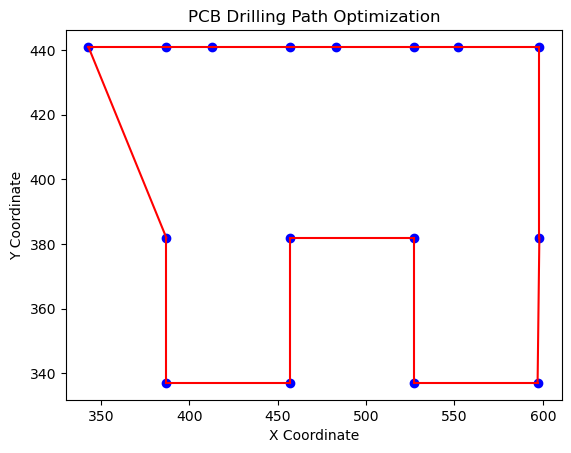

In [28]:
genetic, sa, ps, t1 = main(df_lsts[2])
plot_solution(df_lsts[2], genetic[1])

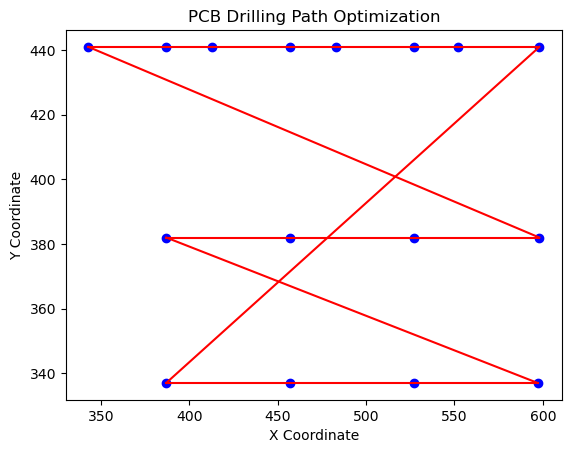

In [29]:
plot_solution(df_lsts[2], sa[0])

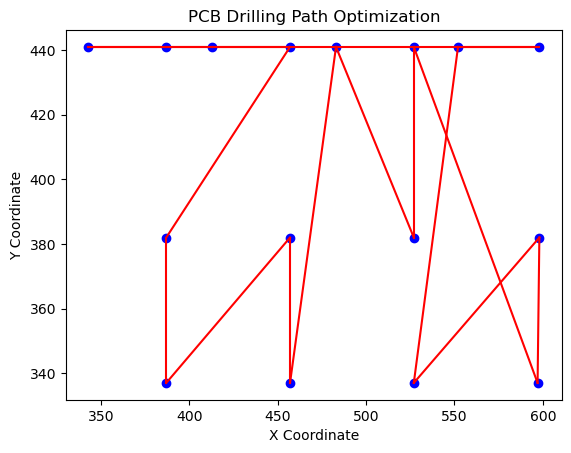

In [30]:
plot_solution(df_lsts[2], ps[0])

Running Genetic Algorithm...
Generation 10: 4804.043948379176
Generation 20: 3668.758438363488
Generation 30: 3428.7751854025846
Generation 40: 2746.513628022528
Generation 50: 2535.8825036617845
Generation 60: 2427.574494107135
Generation 70: 2288.1849516874768
Generation 80: 2189.5744941071343
Generation 90: 2129.5744941071343
Generation 100: 2117.8825036617845
Generation 110: 2117.8825036617845
Generation 120: 2024.945308410889
Generation 130: 2024.945308410889
Generation 140: 2024.945308410889
Generation 150: 2024.945308410889
Generation 160: 1994.0066988892215
Generation 170: 1963.0011185668332
Generation 180: 1963.0011185668332
Generation 190: 1963.0011185668332
Generation 200: 1963.0011185668332
Genetic Algorithm Best Distance: 1963.0011185668332
Time: 0.8815937042236328

Running Simulated Annealing...
Simulated Annealing Best Distance: 2462.5556722118417
Time: 0.025098323822021484

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 7120.7631565113

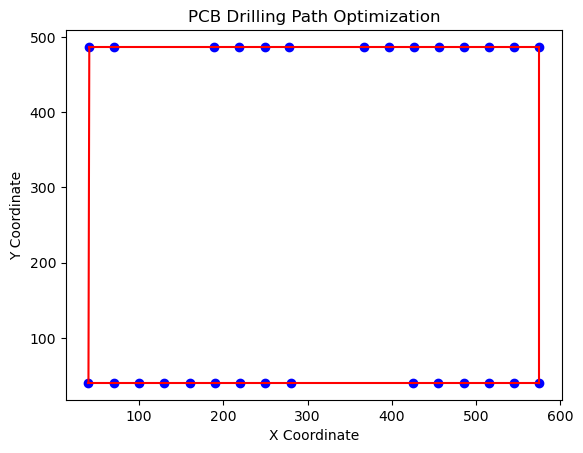

In [31]:
genetic, sa, ps, t1 = main(df_lsts[3])
plot_solution(df_lsts[3], genetic[1])

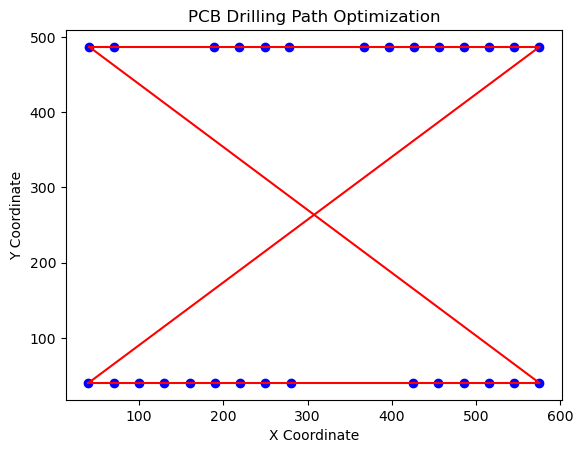

In [32]:
plot_solution(df_lsts[3], sa[0])

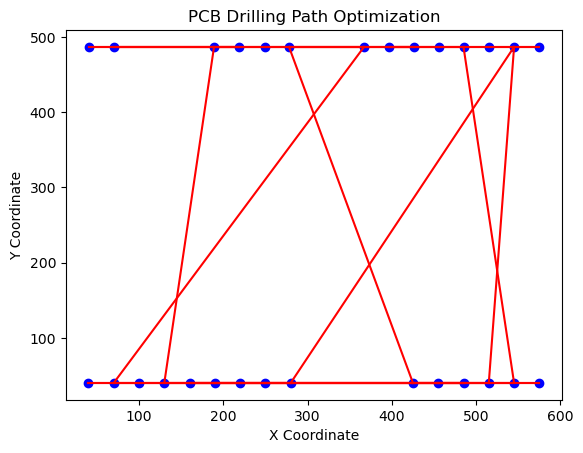

In [33]:
plot_solution(df_lsts[3], ps[0])

Running Genetic Algorithm...
Genetic Algorithm Best Distance: 193.48655719667784
Time: 0.0019969940185546875

Running Simulated Annealing...
Simulated Annealing Best Distance: 193.48655719667784
Time: 0.010994195938110352

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 176.0
Time: 0.04733157157897949


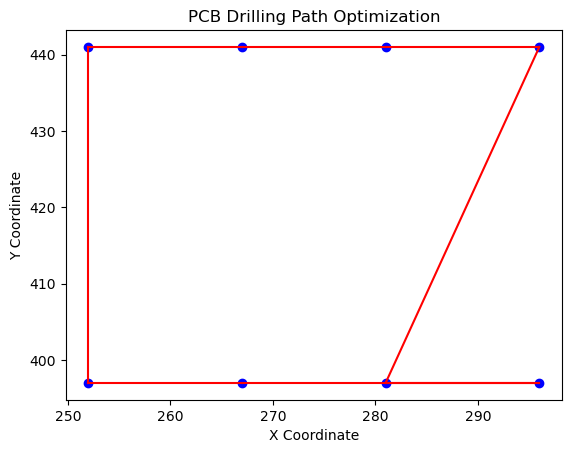

In [34]:
genetic, sa, ps, t1 = main(df_lsts[4])
plot_solution(df_lsts[4], genetic[1])

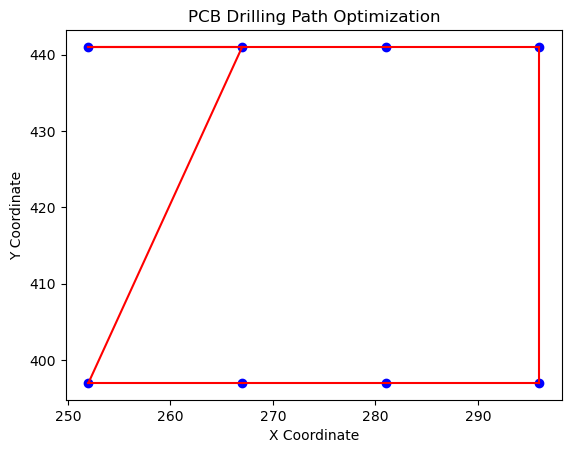

In [35]:
plot_solution(df_lsts[4], sa[0])

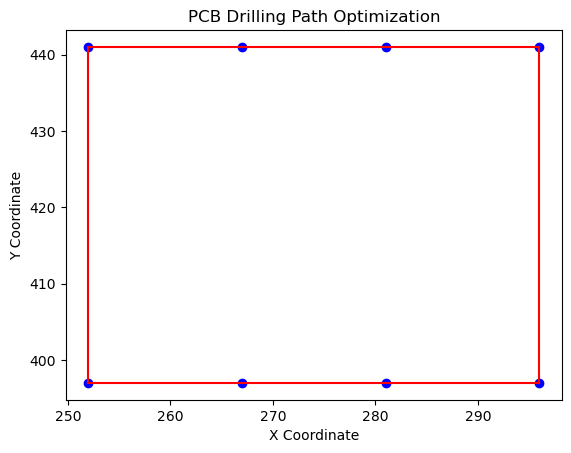

In [36]:
plot_solution(df_lsts[4], ps[0])

Running Genetic Algorithm...
Generation 10: 6078.986242964839
Generation 20: 5149.475921049975
Generation 30: 3830.3639216790266
Generation 40: 3333.2738784645876
Generation 50: 3268.6392142792133
Generation 60: 2984.1026860332227
Generation 70: 2650.404993696894
Generation 80: 2487.9173535885484
Generation 90: 2337.9895401520394
Generation 100: 2337.9895401520394
Generation 110: 2323.2874642199104
Generation 120: 2322.120704262641
Generation 130: 2262.0167735418204
Generation 140: 2262.0167735418204
Generation 150: 2223.183419728171
Generation 160: 2198.0520488222255
Generation 170: 2165.0932180093296
Generation 180: 2160.904853700294
Generation 190: 2143.165607704682
Generation 200: 2130.739200833489
Genetic Algorithm Best Distance: 2130.739200833489
Time: 1.6332776546478271

Running Simulated Annealing...
Simulated Annealing Best Distance: 2712.752168971193
Time: 0.037994384765625

Running Particle Swarm Optimization...
Particle Swarm Optimization Best Distance: 7629.307079055768
Ti

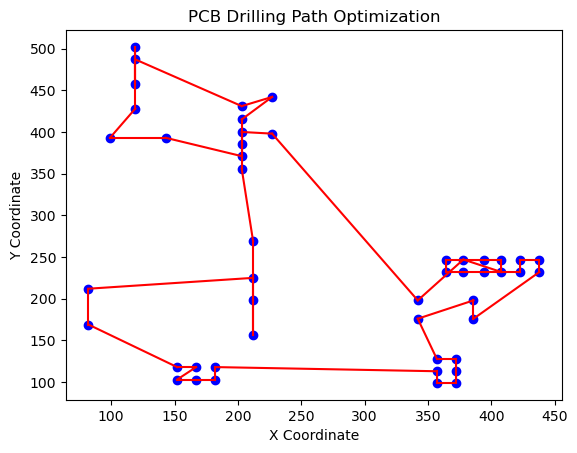

In [37]:
genetic, sa, ps, t1 = main(df_lsts[5])
plot_solution(df_lsts[5], genetic[1])

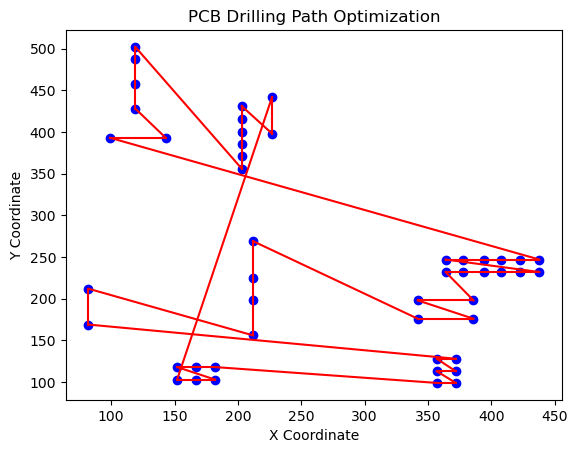

In [38]:
plot_solution(df_lsts[5], sa[0])

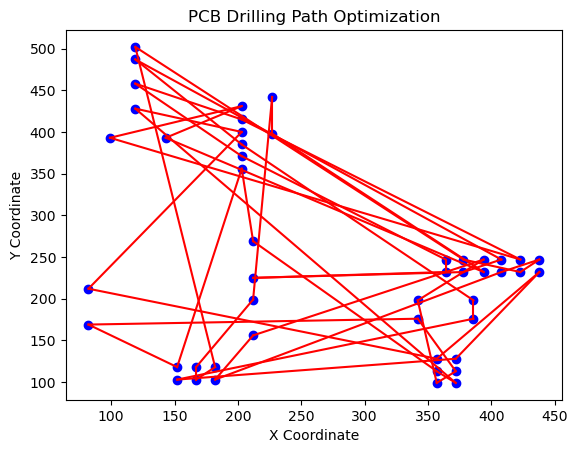

In [39]:
plot_solution(df_lsts[5], ps[0])